# Neural Network Model(ResNet)




In [ ]:
from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)
import six
from math import ceil
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers import (
    Conv3D,
    AveragePooling3D,
    MaxPooling3D
)
from keras.layers import add
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault(
        "kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer",
                                                "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(activation)
    return f


def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] \
        / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] \
        / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] \
        / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 \
            or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(filters=filters, strides=strides,
                                   kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(
                                       is_first_layer and i == 0)
                                   )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),
                           strides=strides, padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer
                           )(input)
        else:
            conv1 = _bn_relu_conv3d(filters=filters,
                                    kernel_size=(3, 3, 3),
                                    strides=strides,
                                    kernel_regularizer=kernel_regularizer
                                    )(input)

        residual = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(filters=filters, kernel_size=(1, 1, 1),
                              strides=strides, padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=kernel_regularizer
                              )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(filters=filters, kernel_size=(1, 1, 1),
                                       strides=strides,
                                       kernel_regularizer=kernel_regularizer
                                       )(input)

        conv_3_3 = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_1_1)
        residual = _bn_relu_conv3d(filters=filters * 4, kernel_size=(1, 1, 1),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError("Input shape should be a tuple "
                             "(conv_dim1, conv_dim2, conv_dim3, channels) "
                             "for tensorflow as backend or "
                             "(channels, conv_dim1, conv_dim2, conv_dim3) "
                             "for theano as backend")

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7),
                                strides=(2, 2, 2),
                                kernel_regularizer=l2(reg_factor)
                                )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2),
                             padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(block_fn, filters=filters,
                                      kernel_regularizer=l2(reg_factor),
                                      repetitions=r, is_first_layer=(i == 0)
                                      )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(pool_size=(block.shape[DIM1_AXIS],
                                            block.shape[DIM2_AXIS],
                                            block.shape[DIM3_AXIS]),
                                 strides=(1, 1, 1))(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="softmax",
                          kernel_regularizer=l2(reg_factor))(flatten1)
        else:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="sigmoid",
                          kernel_regularizer=l2(reg_factor))(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 34."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [3, 4, 6, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 50."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 6, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 101."""
        print("101")
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 4, 23, 3], reg_factor=reg_factor)

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(input_shape, num_outputs, bottleneck,
                                     [3, 8, 36, 3], reg_factor=reg_factor)
        


In [ ]:
def get_compiled(loss='categorical_crossentropy', optimizer='adam',
                 weights=None, **kwargs):
    metrics = ["categorical_accuracy"]
    model = Resnet3DBuilder.build_resnet_101((32, 32, 32, 1), 2)
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=[loss] + metrics)
    
    return model

# Data Pre-processing and Augmentation

In [ ]:
import numpy as np
from tensorflow import keras
import csv
import random
from matplotlib import pyplot as plt


# data augment
def rotation(array, angle):
    X = np.rot90(array, angle[0], axes=(0, 1))  # rotate in X-axis
    Y = np.rot90(X, angle[1], axes=(0, 2))  # rotate in Y'-axis
    Z = np.rot90(Y, angle[2], axes=(1, 2))  # rotate in Z"-axis
    return Z


def reflection(array, axis):
    if axis != -1:
        ref = np.flip(array, axis)
    else:
        ref = np.copy(array)
    return ref


def augment(x_train, y_train):
    print(np.size(x_train, 0))
    for i in range(0, np.size(x_train, 0)):
        angle = (random.randint(0, 3), random.randint(0, 3), random.randint(0, 3))
        rotated_data = rotation(x_train[i], angle)
        axis = random.randint(-1, 2)
        flipped_data = reflection(x_train[i], axis)
        # for j in range(0, 32, 2):
        #     plt.figure()
        #     plt.subplot(1, 3, 1)
        #     plt.imshow(rotated_data[j])
        #     plt.subplot(1, 3, 2)
        #     plt.imshow(flipped_data[j])
        #     plt.subplot(1, 3, 3)
        #     plt.imshow(x_train[i][j])
        #     plt.show()
        x_train = np.append(x_train, np.expand_dims(rotated_data, axis=0), axis=0)
        x_train = np.append(x_train, np.expand_dims(flipped_data, axis=0), axis=0)
        y_train = np.append(y_train, np.expand_dims(y_train[i], axis=0), axis=0)
        y_train = np.append(y_train, np.expand_dims(y_train[i], axis=0), axis=0)
    return x_train, y_train


def load_label():
    path = 'drive/MyDrive/dataset2/train_val.csv'
    y_train = np.loadtxt(path, int, delimiter=",", skiprows=1, usecols=1)
    print('Labels loaded')
    return y_train

import pandas as pd

# load feature original=1->return the augmented data
def load_data(aug=False):
    focus = 16
    x_train = np.ones((365, 2 * focus, 2 * focus, 2 * focus))
    j = 0
    candidates = pd.read_csv('drive/MyDrive/dataset2/train_val.csv')['name']
    for c in candidates:
      a = 'drive/MyDrive/dataset2/train_val/' + c + '.npz'
      tmp = np.load(a)
      voxel = tmp['voxel']
      seg = tmp['seg']
      x_train[j] = (voxel * seg)[50 - focus:50 + focus, 50 - focus:50 + focus, 50 - focus:50 + focus]
      j = j + 1
    # for i in range(0, 480):
    #     a = 'drive/MyDrive/dataset2/train_val/candidate' + str(i) + '.npz'
    #     try:
    #         tmp = np.load(a)
    #         voxel = tmp['voxel']
    #         seg = tmp['seg']
    #         x_train[j] = (voxel * seg)[50 - focus:50 + focus, 50 - focus:50 + focus, 50 - focus:50 + focus]
    #         j = j + 1
    #     except:
    #         continue
    y_train = load_label()
    if aug is False:
        x_train = x_train.reshape(x_train.shape[0], 2 * focus, 2 * focus, 2 * focus, 1)
        y_train = keras.utils.to_categorical(y_train, 2)
        return x_train, y_train
    x_train, y_train = augment(x_train, y_train)
    x_train, y_train = mix_up(x_train, y_train)
    x_train = x_train.reshape(x_train.shape[0], 2 * focus, 2 * focus, 2 * focus, 1)
    y_train = keras.utils.to_categorical(y_train, 2)
    return x_train, y_train


def mix_up(x_train, y_train, increment=400):
    t = 0.5
    x = np.ones((increment, 32, 32, 32))
    y = np.ones(increment)
    i = 0
    size = np.size(x_train, 0)
    while i < increment:
        m = random.randint(0, size - 1)
        n = random.randint(0, size - 1)
        if y_train[m] == y_train[n]:
            x[i] = (t * x_train[m] + (1 - t) * x_train[n]).copy()
            y[i] = (t * y_train[m] + (1 - t) * y_train[n]).copy()
            i = i + 1
    # i = 0
    # for j in range(0, 32, 2):
    #     plt.figure()
    #     plt.subplot(1, 2, 1)
    #     plt.imshow(x[i][j])
    #     plt.subplot(1, 2, 2)
    #     plt.imshow(x_train[i][j])
    #     plt.show()
    final_x = np.append(x_train, x, axis=0)
    final_y = np.append(y_train, y)
    return final_x, final_y


# Self-Customized AUC Score Callback

In [ ]:
# use sckit-learn to build the evaluation function
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

AUC_Scores = []

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.x_val,self.y_val = validation_data
    def on_epoch_end(self, epoch, log={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print('\n ROC_AUC - epoch:%d - score:%.6f' % (epoch+1, score))
            AUC_Scores.append(score)
            


# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training Function

In [ ]:
def train_model(x_train, y_train, x_val, y_val, epoch, batch_size, save_weight_path, load_weight_path):

  RocAuc = RocAucEvaluation(validation_data=(x_val, y_val), interval=1)

  tf.compat.v1.disable_eager_execution()

  # compile model
  model = get_compiled()
  # model_path = 'tmp/weights0618.09.h5'
  # model.load_weights(model_path)

  if load_weight_path != '':
    model.load_weights(load_weight_path)
    
    print("Weight Loaded! " + load_weight_path)
  # train
  checkpointer = ModelCheckpoint(filepath= save_weight_path + '.{epoch:02d}.h5', verbose=1,
                                  period=1, save_weights_only=True)
  history = model.fit(x_train,
            y_train,
            epochs=epoch,
            validation_data=(x_val, y_val),
            shuffle=True,
            batch_size=batch_size,
            callbacks=[RocAuc,checkpointer]
            )
  return history

# Train with Original Data

Labels loaded
Labels loaded
(365, 32, 32, 32, 1) (365, 2)
(365, 32, 32, 32, 1) (365, 2)
101


Train on 365 samples, validate on 365 samples
Epoch 1/30
365/365 [==============================] - ETA: 0s - loss: 11.6089 - categorical_crossentropy: 1.2272 - categorical_accuracy: 0.5534

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



 ROC_AUC - epoch:1 - score:0.500000

Epoch 1: saving model to drive/MyDrive/res_tmp/res101_weights1210_original_data.01.h5
365/365 [==============================] - 345s 945ms/sample - loss: 11.6089 - categorical_crossentropy: 1.2272 - categorical_accuracy: 0.5534 - val_loss: 93388.0755 - val_categorical_crossentropy: 93377.8438 - val_categorical_accuracy: 0.4603
Epoch 2/30
365/365 [==============================] - ETA: 0s - loss: 10.7715 - categorical_crossentropy: 0.6595 - categorical_accuracy: 0.6164
 ROC_AUC - epoch:2 - score:0.460902

Epoch 2: saving model to drive/MyDrive/res_tmp/res101_weights1210_original_data.02.h5
365/365 [==============================] - 12s 33ms/sample - loss: 10.7715 - categorical_crossentropy: 0.6595 - categorical_accuracy: 0.6164 - val_loss: 789.2955 - val_categorical_crossentropy: 779.3474 - val_categorical_accuracy: 0.4603
Epoch 3/30
365/365 [==============================] - ETA: 0s - loss: 10.3809 - categorical_crossentropy: 0.6065 - categorical_

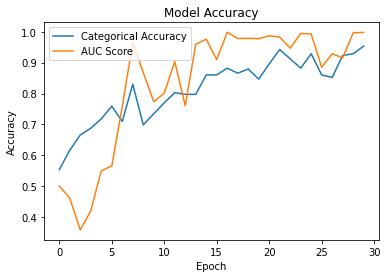

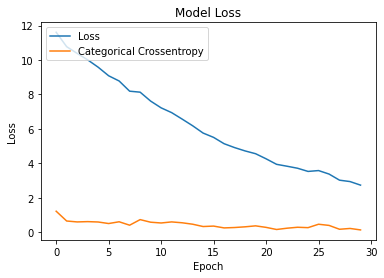

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt


import tensorflow as tf
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

x_train, y_train = load_data()
x_val, y_val = load_data()
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

save_weight_path = 'drive/MyDrive/res_tmp/res101_weights1210_original_data'
load_weight_path = ''
batch_size = 16
epoch = 30

AUC_Scores = []
ori_history = train_model(x_train, y_train, x_val, y_val, epoch, batch_size, save_weight_path, load_weight_path)

plt.plot(ori_history.history['categorical_accuracy'])
plt.plot(AUC_Scores)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Categorical Accuracy', 'AUC Score'], loc='upper left')
plt.show()

plt.plot(ori_history.history['loss'])
plt.plot(ori_history.history['categorical_crossentropy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Categorical Crossentropy'], loc='upper left')
plt.show()





# Testing Function

In [ ]:
from pandas.io.parsers.python_parser import parser_defaults
import os
import numpy as np
# from mylib.densenet import get_compiled
import tensorflow as tf
import os
import pandas as pd
import sklearn.metrics

def load_test():
    x_test = np.ones((100, 32, 32, 32))
    i = 0
    path = TEST_PATH  
    path_list = os.listdir(path)
    path_list.sort()  
    for filename in path_list:
        tmp = np.load(os.path.join(path, filename))
        voxel = tmp['voxel']
        seg = tmp['seg']
        x_test[i] = (voxel * seg)[50 - 16:50 + 16, 50 - 16:50 + 16, 50 - 16:50 + 16]
        i = i + 1
    x_test = x_test.reshape(x_test.shape[0], 32, 32, 32, 1)
    return x_test

def save_sub(input_list):
  candidates = list()
  for c in os.listdir(TEST_PATH):
    candidates.append(c.split(".")[0])
  candidates.sort()
  data = {"name": candidates, "label": input_list[:, 1]}
  df = pd.DataFrame(data)
  df.to_csv(SUBMISSION_CSV)
  print('File saved')

def test_model(TEST_CSV, TEST_PATH, SUBMISSION_CSV, TRAIN_MODEL_PATH):
  x_test = load_test()
  model = get_compiled()
  score_map = {} 
  labels_map = {}
  test_score = []

  best_score = 0
  second_best_score = 0
  best_weights = -1
  second_best_weights = -1

  true_labels = pd.read_csv(TEST_CSV)['label']

  for i in range(1, 30):
      if i < 10:
        model_path = TRAIN_MODEL_PATH + "0" + str(i) + '.h5'
      else:
        model_path = TRAIN_MODEL_PATH + str(i) + '.h5'
      model.load_weights(model_path)
      res = model.predict(x_test, batch_size, verbose=1)

      save_sub(res)
      file = pd.read_csv(SUBMISSION_CSV)
      
      predicted_labels = file['label']
      labels_map[i] = predicted_labels
      score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
      test_score.append(score)
      score_map[i] = score
      if score > best_score:
        best_score = score
        best_weights = i
      elif score > second_best_score:
        second_best_score = score
        second_best_weights = i

  first_score = 0
  best_i = 0
  best_j = 0
  for i in range (1, 30):
    for j in range(i + 1, 30):
      best1 = [i * 0.5 for i in labels_map[i]]
      best2 = [i * 0.5 for i in labels_map[j]]
      predicted_labels = np.sum([best1, best2], axis = 0)
      score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
      if score > first_score:
        first_score = score
        best_i = i
        best_j = j

  print(first_score)
  print(best_i)
  print(best_j)
  # best1 = [i * 0.5 for i in labels_map[best_weights]]
  # best2 = [i * 0.5 for i in labels_map[second_best_weights]]
  # predicted_labels = np.sum([best1, best2], axis = 0)
  # score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
  # print(score)
  print(score_map)
  print("Test AUC Mean",np.mean(np.array(test_score)))
  print()
  print("Epoch: " + str(best_weights))
  print(labels_map[best_weights])
  print()
  print("Epoch: " + str(second_best_weights))
  print(labels_map[second_best_weights])

# Test the Unaugmented Data Model

In [ ]:

batch_size = 16
TEST_CSV = 'drive/MyDrive/dataset2/test_val.csv'
TEST_PATH = "drive/MyDrive/dataset2/test"
SUBMISSION_CSV = "drive/MyDrive/dataset2/result.csv"
TRAIN_MODEL_PATH = "drive/MyDrive/res_tmp/res101_weights1210_original_data."

test_model(TEST_CSV, TEST_PATH, SUBMISSION_CSV, TRAIN_MODEL_PATH)





101


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
0.6588
10
19
{1: 0.5, 2: 0.4492, 3: 0.3556, 4: 0.36920000000000003, 5: 0.3748, 6: 0.33359999999999995, 7: 0.4532, 8: 0.4968, 9: 0.488, 10: 0.6266, 11: 0.5216000000000001, 12: 0.5939999999999999, 13: 0.4792, 14: 0.6012000000000001, 15: 0.5476, 16: 0.6136, 17: 0.5640000000000001, 18: 0.5108, 19: 0.5576, 20: 0.5968, 21: 0.5496000000000001, 22: 0.6228, 23: 0.6376, 24: 0.5392, 25: 0.6376000000000001, 26: 0.6412000000000001, 27: 0.5107999999999999, 28: 0.49, 29: 0.6036}
Test AUC Mean 0.5264068965517241

Epoch: 26
0     0.353257
1     0.071233
2     0.996519
3     0.963253
4     0.149635
        ...   
95    0.019114
96    0.999962
97    0.816411
98    0.998692
99    0.147826
Nam

# Get the Best Weight

In [ ]:
import numpy
auc_original = numpy.array(AUC_Scores)
print(auc_original)
max_index = auc_original.argmax() + 1
max_val = np.max(auc_original)
min_val = np.min(auc_original)
mean_val = np.mean(auc_original)

print("Best Weight's Epoch is:", max_index)
print("Max Score is ", max_val)
print("Min Score is ", min_val)
print("Mean Score is ", mean_val)




[0.5        0.46090162 0.35817017 0.42019428 0.54990029 0.56506829
 0.75788615 0.96552453 0.86814117 0.77314479 0.80128263 0.90364394
 0.76045444 0.95942108 0.97597897 0.9095359  0.99845903 0.97824511
 0.97857747 0.97776166 0.98694706 0.98280759 0.94691201 0.99450085
 0.99271815 0.88509185 0.92881315 0.91560914 0.99634397 0.99824752]
Best Weight's Epoch is: 17
Max Score is  0.9984590282813632
Min Score is  0.3581701716219483
Mean Score is  0.8363427604544353


# Train with the Augmented data and the best Weight

Labels loaded
365
Labels loaded
(1495, 32, 32, 32, 1) (1495, 2)
(365, 32, 32, 32, 1) (365, 2)
101


Weight Loaded! drive/MyDrive/res_tmp/res101_weights1210_original_data.17.h5
Train on 1495 samples, validate on 365 samples
Epoch 1/30
1495/1495 [==============================] - ETA: 0s - loss: 3.7243 - categorical_crossentropy: 0.6472 - categorical_accuracy: 0.7084

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



 ROC_AUC - epoch:1 - score:0.873837

Epoch 1: saving model to drive/MyDrive/res_tmp/res101_weights1210_aug_data.01.h5
1495/1495 [==============================] - 483s 323ms/sample - loss: 3.7243 - categorical_crossentropy: 0.6472 - categorical_accuracy: 0.7084 - val_loss: 2.9834 - val_categorical_crossentropy: 1.0571 - val_categorical_accuracy: 0.6767
Epoch 2/30
1495/1495 [==============================] - ETA: 0s - loss: 2.0590 - categorical_crossentropy: 0.5953 - categorical_accuracy: 0.7405
 ROC_AUC - epoch:2 - score:0.559229

Epoch 2: saving model to drive/MyDrive/res_tmp/res101_weights1210_aug_data.02.h5
1495/1495 [==============================] - 33s 22ms/sample - loss: 2.0590 - categorical_crossentropy: 0.5953 - categorical_accuracy: 0.7405 - val_loss: 242.4412 - val_categorical_crossentropy: 241.2070 - val_categorical_accuracy: 0.4877
Epoch 3/30
1495/1495 [==============================] - ETA: 0s - loss: 1.7356 - categorical_crossentropy: 0.6457 - categorical_accuracy: 0.70

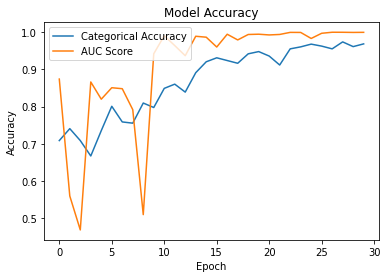

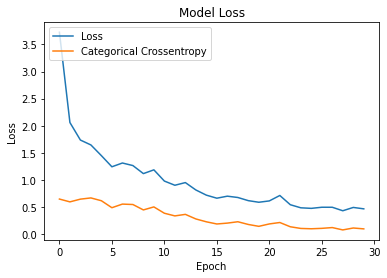

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt


import tensorflow as tf
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

x_train, y_train = load_data(True)
x_val, y_val = load_data()
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

save_weight_path = 'drive/MyDrive/res_tmp/res101_weights1210_aug_data'
if max_index < 10:
  load_weight_path = 'drive/MyDrive/res_tmp/res101_weights1210_original_data.' + "0" + str(max_index) + '.h5'
else:
  load_weight_path = 'drive/MyDrive/res_tmp/res101_weights1210_original_data.' + str(max_index) + '.h5'

batch_size = 16
epoch = 30

AUC_Scores = []
aug_history = train_model(x_train, y_train, x_val, y_val, epoch, batch_size, save_weight_path, load_weight_path)

plt.plot(aug_history.history['categorical_accuracy'])
plt.plot(AUC_Scores)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Categorical Accuracy', 'AUC Score'], loc='upper left')
plt.show()

plt.plot(aug_history.history['loss'])
plt.plot(aug_history.history['categorical_crossentropy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Categorical Crossentropy'], loc='upper left')
plt.show()

# Test the Augmented Data Model

In [ ]:

batch_size = 16
TEST_CSV = 'drive/MyDrive/dataset2/test_val.csv'
TEST_PATH = "drive/MyDrive/dataset2/test"
SUBMISSION_CSV = "drive/MyDrive/dataset2/result.csv"
TRAIN_MODEL_PATH = "drive/MyDrive/res_tmp/res101_weights1210_aug_data."

test_model(TEST_CSV, TEST_PATH, SUBMISSION_CSV, TRAIN_MODEL_PATH)

101


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
0.65
8
21
{1: 0.5728, 2: 0.37260000000000004, 3: 0.3696, 4: 0.49760000000000004, 5: 0.6072000000000001, 6: 0.6307999999999999, 7: 0.6075999999999999, 8: 0.652, 9: 0.36439999999999995, 10: 0.5840000000000001, 11: 0.55, 12: 0.6168, 13: 0.6428, 14: 0.5464, 15: 0.632, 16: 0.5983999999999999, 17: 0.5744, 18: 0.606, 19: 0.5704, 20: 0.5536, 21: 0.636, 22: 0.5836, 23: 0.5860000000000001, 24: 0.5935999999999999, 25: 0.6020000000000001, 26: 0.5836, 27: 0.5292, 28: 0.5572, 29: 0.5724}
Test AUC Mean 0.5652758620689655

Epoch: 8
0     0.646186
1     0.568324
2     0.990685
3     0.894865
4     0.759744
        ...   
95    0.525139
96    0.997603
97    0.964988
98    0.999999
99    0.6

## More Statistics

In [ ]:
import numpy
auc_aug = numpy.array(AUC_Scores)
print(auc_aug)
max_index = auc_aug.argmax() + 1
max_val = np.max(auc_aug)
min_val = np.min(auc_aug)
mean_val = np.mean(auc_aug)

print("Best Weight's Epoch is:", max_index)
print("Max Score is ", max_val)
print("Min Score is ", min_val)
print("Mean Score is ", mean_val)

[0.87383672 0.55922921 0.46794175 0.86608654 0.81973652 0.85058617
 0.84792724 0.79153825 0.50910231 0.94201716 0.99045202 0.96398356
 0.93674462 0.98906212 0.98655427 0.96011603 0.99453106 0.97918177
 0.99383611 0.99459149 0.99262751 0.99392676 0.99951656 0.99936548
 0.98313996 0.99709935 0.99987914 0.99978849 0.9993957  0.99963742]
Best Weight's Epoch is: 27
Max Score is  0.9998791394730482
Min Score is  0.4679417452260092
Mean Score is  0.9093810430263475
